#### Powtórzenie eksperymentu z artykułu

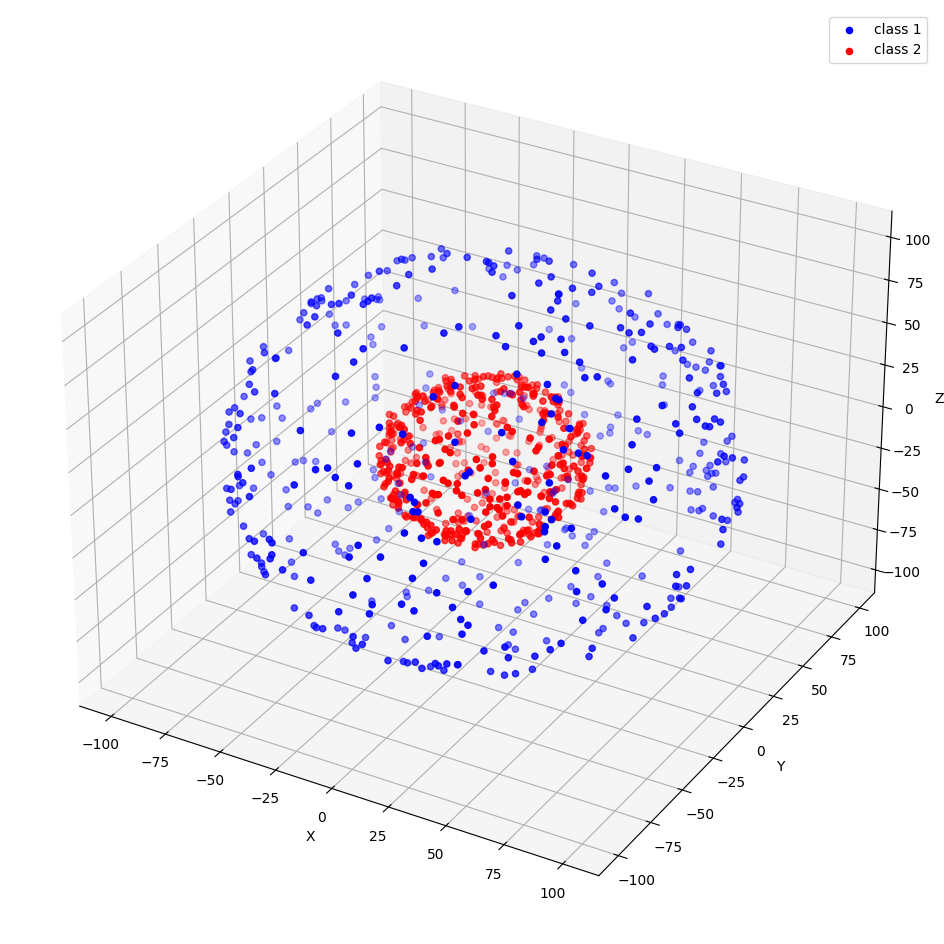

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def generatePointsOnSphere(r, num_points, std_dev):
    phi_1 = np.random.uniform(0, 2*np.pi, num_points)
    theta_1 = np.arccos(np.random.uniform(-1, 1, num_points))
    x = r * np.sin(theta_1) * np.cos(phi_1)
    y = r * np.sin(theta_1) * np.sin(phi_1)
    z = r * np.cos(theta_1)

    x_p = x + np.random.normal(0, std_dev, size=len(x))
    y_p = y + np.random.normal(0, std_dev, size=len(y))
    z_p = z + np.random.normal(0, std_dev, size=len(z))
    
    return x_p, y_p, z_p


num_points = 500
std_dev = 1

r_1 = 100
x_1, y_1, z_1 = generatePointsOnSphere(r_1, num_points, std_dev)

r_2 = 40
x_2, y_2, z_2 = generatePointsOnSphere(r_2, num_points, std_dev)

fig = plt.figure(figsize=(15, 12))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x_1, y_1, z_1, color='blue', label='class 1')
ax.scatter(x_2, y_2, z_2, color='red', label='class 2')

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()

plt.show()

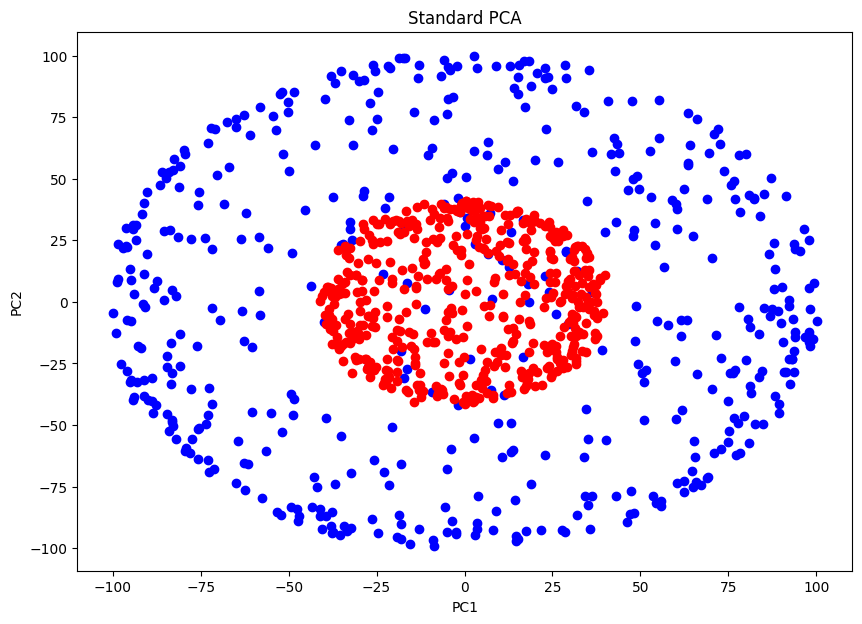

In [3]:
from sklearn.decomposition import PCA

X = np.array([np.concatenate((x_1, x_2)), np.concatenate((y_1, y_2)), np.concatenate((z_1, z_2))]).T

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(10, 7))
plt.scatter(X_pca[:500, 0], X_pca[:500, 1], color='blue', label='class 1')
plt.scatter(X_pca[-500:, 0], X_pca[-500:, 1], color='red', label='class 2')
plt.title('Standard PCA')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

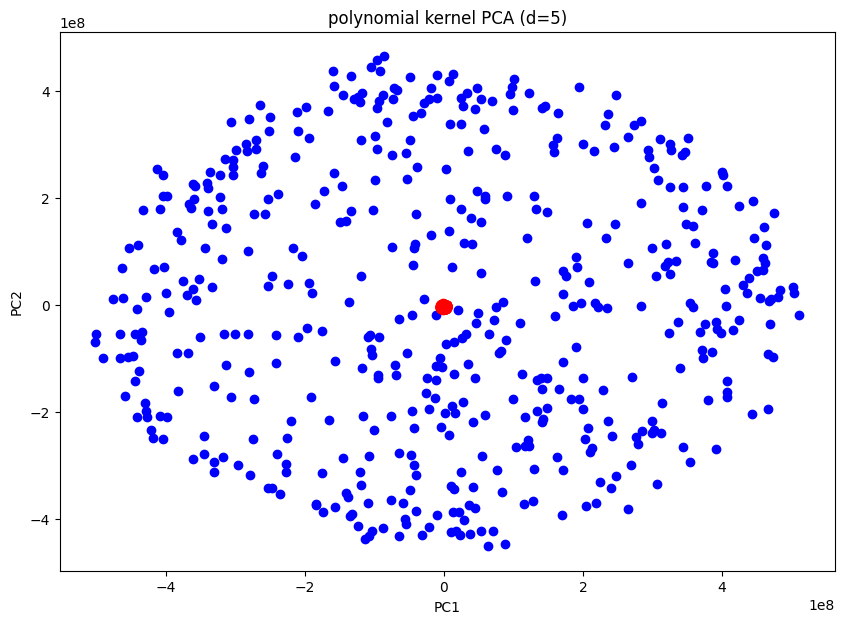

In [4]:
from sklearn.decomposition import KernelPCA

X = np.array([np.concatenate((x_1, x_2)), np.concatenate((y_1, y_2)), np.concatenate((z_1, z_2))]).T

kpca = KernelPCA(n_components=2, kernel='poly', degree=5)
X_kpca = kpca.fit_transform(X)

plt.figure(figsize=(10, 7))
plt.scatter(X_kpca[:500, 0], X_kpca[:500, 1], color='blue', label='class 1')
plt.scatter(X_kpca[-500:, 0], X_kpca[-500:, 1], color='red', label='class 2')
plt.title('polynomial kernel PCA (d=5)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

Jak i u autorów artykułu, zastosowanie kPCA z jądrem wielomianowym o stopniu 5 pozwala dobrze zklastrować elementy jednej z klas, jednakże nie są one liniowo separowalne. Modyfikacja stopnia wielomianu również nie przyniesie poprawy, elementy klasy 2 będą wciąż otoczone przez elementy klasy 1.

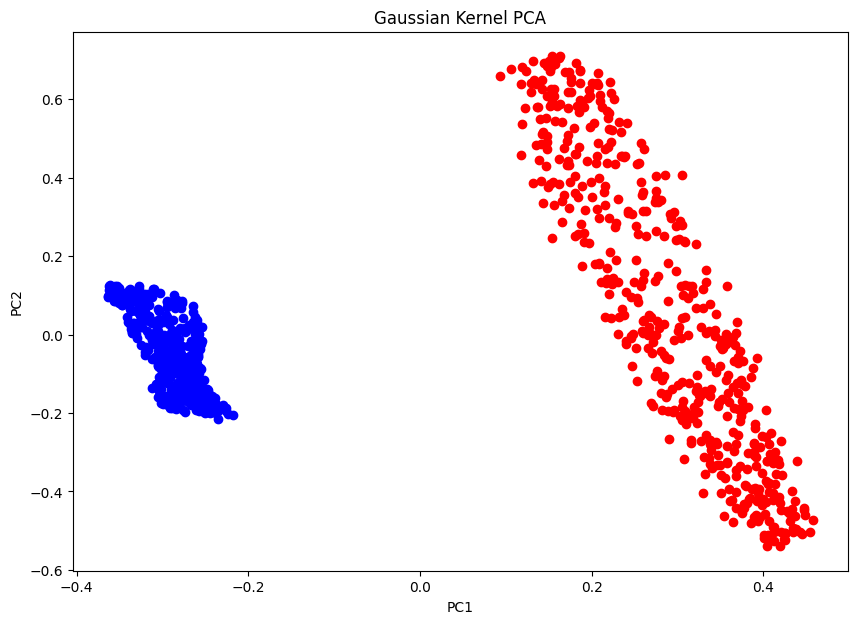

In [5]:
sigma = 35
gamma = 1.0 / (2 * sigma**2)

kpca = KernelPCA(n_components=2, kernel='rbf', gamma=gamma)
X_kpca = kpca.fit_transform(X)

plt.figure(figsize=(10, 7))
plt.scatter(X_kpca[:500, 0], X_kpca[:500, 1], color='blue', label='class 1')
plt.scatter(X_kpca[-500:, 0], X_kpca[-500:, 1], color='red', label='class 2')
plt.title('Gaussian Kernel PCA')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

Dla podanej w artykule wartości sigma = 27.8 nie udało mi się uzyskać rezultatu w nim opisanego. Natomiast przy małej modyfikacji sigma na 35, klasy punktów z zadanego zbioru są liniowo separowalne.

#### Przypadki użycia kPCA z tego zadania i metod klasyfikacji z zadania 3 dla 100 pierwszych komponentów wiodących

In [6]:
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split

lfw_people = fetch_lfw_people(min_faces_per_person=50)

x_train, x_test, y_train, y_test = train_test_split(
    lfw_people.data, lfw_people.target, test_size=0.3, random_state=7)



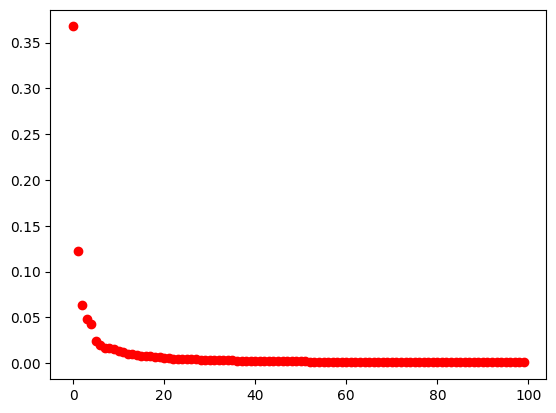

variation sum for first 10 components - kPCA(poly): 0.7390059595927596
variation sum for first 20 components - kPCA(poly): 0.8317350135184824
variation sum for first 50 components - kPCA(poly): 0.9331411276943982
variation sum for first 100 components - kPCA(poly): 1.0000000334111974


In [15]:
X_kpca_100 = KernelPCA(n_components=100, kernel='poly', degree=5)
X_kpca_100.fit(x_train)
x_train_kpca_100 = X_kpca_100.transform(x_train)
x_test_kpca_100 = X_kpca_100.transform(x_test)

total_variance = np.sum(np.var(x_train_kpca_100, axis=0))
variance_ratio = np.var(x_train_kpca_100, axis=0) / total_variance

plt.plot(variance_ratio, 'ro')
plt.show()
print(f'variation sum for first 10 components - kPCA(poly): {sum(variance_ratio[:10])}')
print(f'variation sum for first 20 components - kPCA(poly): {sum(variance_ratio[:20])}')
print(f'variation sum for first 50 components - kPCA(poly): {sum(variance_ratio[:50])}')
print(f'variation sum for first 100 components - kPCA(poly): {sum(variance_ratio[:100])}')

W tym punkcie policzyłem na piechotę wariancje dla każdego z komponentów wiodących kPCA z jądrem wielomianowym.  
Znów optymalną liczbą komponentów wydaje się być ok 10-20. Sprawdzimy to później dla 20, a póki co sklasyfikujmy dane dla 100 pierwszych komponentów wiodących.

In [8]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_recall_fscore_support

#higher iteration number needed for convergence 
mlp_clf = MLPClassifier(max_iter=900, random_state=7)
mlp_clf.fit(x_train_kpca_100, y_train)
y_predict = mlp_clf.predict(x_test_kpca_100)

precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_predict)
print('#kPCA_components=100, kernel=poly, MLP classifier:')
for i in range(len(precision)):
    print(f'class: {i}, precision: {precision[i]}, recall: {recall[i]}, f1 score: {fscore[i]}')

precision_avg, recall_avg, f1_score_avg, _ = precision_recall_fscore_support(y_test, y_predict, average='weighted')
print(f'avg-values -> precision: {precision[i]}, recall: {recall[i]}, f1 score: {fscore[i]}')

#kPCA_components=100, kernel=poly, MLP classifier:
class: 0, precision: 0.6666666666666666, recall: 0.8888888888888888, f1 score: 0.7619047619047619
class: 1, precision: 0.7843137254901961, recall: 0.7692307692307693, f1 score: 0.7766990291262136
class: 2, precision: 0.7878787878787878, recall: 0.65, f1 score: 0.7123287671232876
class: 3, precision: 0.8475609756097561, recall: 0.8910256410256411, f1 score: 0.86875
class: 4, precision: 0.7045454545454546, recall: 0.7380952380952381, f1 score: 0.7209302325581395
class: 5, precision: 0.9047619047619048, recall: 0.76, f1 score: 0.8260869565217391
class: 6, precision: 0.46153846153846156, recall: 0.5454545454545454, f1 score: 0.5
class: 7, precision: 0.8461538461538461, recall: 0.6875, f1 score: 0.7586206896551724
class: 8, precision: 0.9, recall: 0.5625, f1 score: 0.6923076923076923
class: 9, precision: 0.782608695652174, recall: 0.9, f1 score: 0.8372093023255814
class: 10, precision: 0.9375, recall: 0.8333333333333334, f1 score: 0.8823529

W przypadku klasyfikatora MLP musieliśmy zwięszyć liczbę iteracji do 900, ponieważ dla użytej w zadaniu wartości 500, optymalizator stochastyczny wciąż nie był zbieżny.
Jak widzimy na wynikach, zastosowanie wielomianowego kPCA do zredukowania wymiarowości nie pomaga klasyfikatorowi MLP w uzyskaniu lepszych wyników. Wręcz wyniki klasyfikacji stały się gorsze z F1-Score równym 75%, podczas gdy w zadaniu 3, wartość F1-Score dla 100 komponentów wiodących wynosila 79%.

In [9]:
from sklearn.svm import SVC

#empirically selected
sigma = 0.4
gamma = 1.0 / (2 * sigma**2)

svm_clf = SVC(kernel="rbf", gamma=gamma, random_state=7)

svm_clf.fit(x_train_kpca_100, y_train)
y_predict = svm_clf.predict(x_test_kpca_100)

precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_predict, zero_division=0)
print('#kPCA_components=100, kernel=poly, SVM classifier, kernel=RBF:')
for i in range(len(precision)):
    print(f'class: {i}, precision: {precision[i]}, recall: {recall[i]}, f1 score: {fscore[i]}',)

precision_avg, recall_avg, f1_score_avg, _ = precision_recall_fscore_support(y_test, y_predict, average='weighted', zero_division=0)
print(f'avg-values -> precision: {precision[i]}, recall: {recall[i]}, f1 score: {fscore[i]}')


#kPCA_components=100, PCA-kernel=poly, SVM classifier, kernel=RBF:
class: 0, precision: 1.0, recall: 0.4444444444444444, f1 score: 0.6153846153846154
class: 1, precision: 0.6176470588235294, recall: 0.8076923076923077, f1 score: 0.7
class: 2, precision: 0.75, recall: 0.45, f1 score: 0.5625
class: 3, precision: 0.5376344086021505, recall: 0.9615384615384616, f1 score: 0.6896551724137931
class: 4, precision: 0.9285714285714286, recall: 0.30952380952380953, f1 score: 0.4642857142857143
class: 5, precision: 1.0, recall: 0.28, f1 score: 0.4375
class: 6, precision: 0.0, recall: 0.0, f1 score: 0.0
class: 7, precision: 1.0, recall: 0.375, f1 score: 0.5454545454545454
class: 8, precision: 1.0, recall: 0.0625, f1 score: 0.11764705882352941
class: 9, precision: 1.0, recall: 0.5, f1 score: 0.6666666666666666
class: 10, precision: 0.9411764705882353, recall: 0.8888888888888888, f1 score: 0.9142857142857143
class: 11, precision: 0.7352941176470589, recall: 0.46296296296296297, f1 score: 0.5681818181

W tym wypadku SVM z jądrem RBF uzyskuje również gorsze wyniki dla danych po kPCA z jądrem wielomianowym, niż dla PCA z poprzedniego zadania. W poprzednim zadaniu F1-Score dla klasyfikatora SVM z RBF wynosil 62%, podczas gdy tutaj osiognąłem maksymalnie 57%.

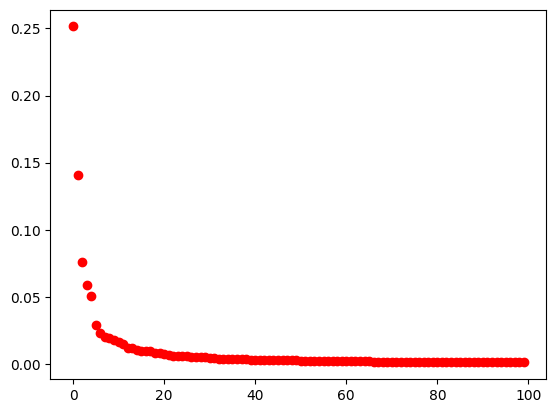

variation sum for first 10 components - kPCA(RBF): 0.6863430049270391
variation sum for first 20 components - kPCA(RBF): 0.7968963691964746
variation sum for first 50 components - kPCA(RBF): 0.9203647458925843
variation sum for first 100 components - kPCA(RBF): 0.9999999538995326


In [20]:
X_kpca_100 = KernelPCA(n_components=100, kernel='rbf', gamma=gamma)
X_kpca_100.fit(x_train)
x_train_kpca_100 = X_kpca_100.transform(x_train)
x_test_kpca_100 = X_kpca_100.transform(x_test)

total_variance = np.sum(np.var(x_train_kpca_100, axis=0))
variance_ratio = np.var(x_train_kpca_100, axis=0) / total_variance

plt.plot(variance_ratio, 'ro')
plt.show()
print(f'variation sum for first 10 components - kPCA(RBF): {sum(variance_ratio[:10])}')
print(f'variation sum for first 20 components - kPCA(RBF): {sum(variance_ratio[:20])}')
print(f'variation sum for first 50 components - kPCA(RBF): {sum(variance_ratio[:50])}')
print(f'variation sum for first 100 components - kPCA(RBF): {sum(variance_ratio[:100])}')

Sumy wariancji niższe, niż w poprzedniej sekcji, ale wyraźne wskazanie na optymalną liczbę komponentów w okolicy 10-20 jest wciąż zachowane.

In [22]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_recall_fscore_support

#higher iteration number needed for convergence 
mlp_clf = MLPClassifier(max_iter=1500, random_state=7)
mlp_clf.fit(x_train_kpca_100, y_train)
y_predict = mlp_clf.predict(x_test_kpca_100)

precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_predict)
print('#kPCA_components=100, kernel=rbf, MLP classifier:')
for i in range(len(precision)):
    print(f'class: {i}, precision: {precision[i]}, recall: {recall[i]}, f1 score: {fscore[i]}')

precision_avg, recall_avg, f1_score_avg, _ = precision_recall_fscore_support(y_test, y_predict, average='weighted')
print(f'avg-values -> precision: {precision[i]}, recall: {recall[i]}, f1 score: {fscore[i]}')

#PCA_components=100, kernel=rbf, MLP classifier:
class: 0, precision: 0.6818181818181818, recall: 0.8333333333333334, f1 score: 0.75
class: 1, precision: 0.7321428571428571, recall: 0.7884615384615384, f1 score: 0.7592592592592593
class: 2, precision: 0.7878787878787878, recall: 0.65, f1 score: 0.7123287671232876
class: 3, precision: 0.869281045751634, recall: 0.8525641025641025, f1 score: 0.86084142394822
class: 4, precision: 0.75, recall: 0.7142857142857143, f1 score: 0.7317073170731707
class: 5, precision: 0.8947368421052632, recall: 0.68, f1 score: 0.7727272727272727
class: 6, precision: 0.29411764705882354, recall: 0.45454545454545453, f1 score: 0.35714285714285715
class: 7, precision: 0.7142857142857143, recall: 0.625, f1 score: 0.6666666666666666
class: 8, precision: 0.8181818181818182, recall: 0.5625, f1 score: 0.6666666666666666
class: 9, precision: 0.7083333333333334, recall: 0.85, f1 score: 0.7727272727272727
class: 10, precision: 0.9375, recall: 0.8333333333333334, f1 score

Przy danych przekształconych przez kPCA(rbf) i sklasyfikowanych przez MLP osiągamy nie tylko gorsze wyniki od tych z liniowym PCA z poprzedniego zadania, ale również od kPCA(poly) z poprzedniej sekcji. Winnym takiemu satnowi rzeczy wydaje się być znaczny spadek parametru "precision", a więc dla odmiany możemy mieć problem z "false positives".

In [23]:
from sklearn.svm import SVC

svm_clf = SVC(random_state=7)

svm_clf.fit(x_train_kpca_100, y_train)
y_predict = svm_clf.predict(x_test_kpca_100)

precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_predict)
print('#kPCA_components=100, kernel=rbf, SVM classifier, kernel=rbf:')
for i in range(len(precision)):
    print(f'class: {i}, precision: {precision[i]}, recall: {recall[i]}, f1 score: {fscore[i]}')

precision_avg, recall_avg, f1_score_avg, _ = precision_recall_fscore_support(y_test, y_predict, average='weighted')
print(f'avg-values -> precision: {precision[i]}, recall: {recall[i]}, f1 score: {fscore[i]}')

#PCA_components=100, kernel=rbfm, SVM classifier:
class: 0, precision: 0.9090909090909091, recall: 0.5555555555555556, f1 score: 0.6896551724137931
class: 1, precision: 0.6567164179104478, recall: 0.8461538461538461, f1 score: 0.7394957983193278
class: 2, precision: 0.7777777777777778, recall: 0.525, f1 score: 0.6268656716417911
class: 3, precision: 0.592156862745098, recall: 0.967948717948718, f1 score: 0.7347931873479319
class: 4, precision: 0.8235294117647058, recall: 0.3333333333333333, f1 score: 0.4745762711864407
class: 5, precision: 1.0, recall: 0.4, f1 score: 0.5714285714285714
class: 6, precision: 1.0, recall: 0.09090909090909091, f1 score: 0.16666666666666666
class: 7, precision: 1.0, recall: 0.375, f1 score: 0.5454545454545454
class: 8, precision: 1.0, recall: 0.125, f1 score: 0.2222222222222222
class: 9, precision: 0.9333333333333333, recall: 0.7, f1 score: 0.8
class: 10, precision: 0.9411764705882353, recall: 0.8888888888888888, f1 score: 0.9142857142857143
class: 11, prec

Przy zastosowaniu kPCA(rbf) i SVM(rbf) orzymujemy jakość klasyfikacji niemalże identyczną do tej z poprzedniego zadania dla liniowego PCA i SVM(rbf). Najpewniej dzieje się tak, gdyż podwójne zastosowanie tego samego jądra, w tym wypadku RBF, do przekształcenia danych podczas ich przygotowywania i ich klasyfikacji nie zmienia w znaczący sposób wyników względem pojedyńczej transformacji wybranym jądrem.  
Obserwacja ta zachęciła nie do przygotowania dodatkowego notatnika, w którym przeprowadzam mały eksperyment.

#### Przypadki użycia kPCA z tego zadania i metod klasyfikacji z zadania 3 dla 50 pierwszych komponentów wiodących

In [24]:
X_kpca_50 = KernelPCA(n_components=50, kernel='poly', degree=5)
X_kpca_50.fit(x_train)
x_train_kpca_50 = X_kpca_50.transform(x_train)
x_test_kpca_50 = X_kpca_50.transform(x_test)

In [28]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_recall_fscore_support

mlp_clf = MLPClassifier(max_iter=1500, random_state=7)
mlp_clf.fit(x_train_kpca_50, y_train)
y_predict = mlp_clf.predict(x_test_kpca_50)

precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_predict)
print('#kPCA_components=50, kernel=poly, MLP classifier:')
for i in range(len(precision)):
    print(f'class: {i}, precision: {precision[i]}, recall: {recall[i]}, f1 score: {fscore[i]}')

precision_avg, recall_avg, f1_score_avg, _ = precision_recall_fscore_support(y_test, y_predict, average='weighted')
print(f'avg-values -> precision: {precision[i]}, recall: {recall[i]}, f1 score: {fscore[i]}')

#kPCA_components=50, kernel=poly, MLP classifier:
class: 0, precision: 0.6521739130434783, recall: 0.8333333333333334, f1 score: 0.7317073170731707
class: 1, precision: 0.7307692307692307, recall: 0.7307692307692307, f1 score: 0.7307692307692307
class: 2, precision: 0.75, recall: 0.6, f1 score: 0.6666666666666666
class: 3, precision: 0.8545454545454545, recall: 0.9038461538461539, f1 score: 0.8785046728971962
class: 4, precision: 0.6666666666666666, recall: 0.6666666666666666, f1 score: 0.6666666666666666
class: 5, precision: 0.6521739130434783, recall: 0.6, f1 score: 0.625
class: 6, precision: 0.4, recall: 0.5454545454545454, f1 score: 0.46153846153846156
class: 7, precision: 0.8461538461538461, recall: 0.6875, f1 score: 0.7586206896551724
class: 8, precision: 0.7142857142857143, recall: 0.625, f1 score: 0.6666666666666666
class: 9, precision: 0.85, recall: 0.85, f1 score: 0.85
class: 10, precision: 0.9411764705882353, recall: 0.8888888888888888, f1 score: 0.9142857142857143
class: 11

Po przeprowadzeniu przygotowania danych przez kPCA(poly) a następnie klasyfikowaniu modelem MLP dla 50 pierwszych komponentów wiodących osiągamy minimalnie lepszą klasyfikację, niż w zadaniu 3 dla transformacji PCA i pozostałych cech przypadku takich samych. Otóż "recall" jest obydwu przypadkach taki sam, natomiast "precision" wzrosła w badanym przypadku z 67,9% na 69,2%, co również pozytywnie wpłynęło na wartość F1-Score.

Zobaczmy, czy dla dalszych przypadków, poprawa klasyfikacji również będzie widoczna

In [52]:
from sklearn.svm import SVC

svm_clf = SVC(kernel="rbf", gamma="scale", random_state=7)

svm_clf.fit(x_train_kpca_50, y_train)
y_predict = svm_clf.predict(x_test_kpca_50)

precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_predict, zero_division=0)
print('#kPCA_components=50, PCA-kernel=poly, SVM classifier, kernel=RBF:')
for i in range(len(precision)):
    print(f'class: {i}, precision: {precision[i]}, recall: {recall[i]}, f1 score: {fscore[i]}',)

precision_avg, recall_avg, f1_score_avg, _ = precision_recall_fscore_support(y_test, y_predict, average='weighted', zero_division=0)
print(f'avg-values -> precision: {precision[i]}, recall: {recall[i]}, f1 score: {fscore[i]}')

#kPCA_components=50, PCA-kernel=poly, SVM classifier, kernel=RBF:
class: 0, precision: 1.0, recall: 0.5555555555555556, f1 score: 0.7142857142857143
class: 1, precision: 0.6567164179104478, recall: 0.8461538461538461, f1 score: 0.7394957983193278
class: 2, precision: 0.8076923076923077, recall: 0.525, f1 score: 0.6363636363636364
class: 3, precision: 0.606425702811245, recall: 0.967948717948718, f1 score: 0.745679012345679
class: 4, precision: 0.7142857142857143, recall: 0.35714285714285715, f1 score: 0.47619047619047616
class: 5, precision: 0.8181818181818182, recall: 0.36, f1 score: 0.5
class: 6, precision: 1.0, recall: 0.09090909090909091, f1 score: 0.16666666666666666
class: 7, precision: 1.0, recall: 0.4375, f1 score: 0.6086956521739131
class: 8, precision: 0.5, recall: 0.0625, f1 score: 0.1111111111111111
class: 9, precision: 0.9285714285714286, recall: 0.65, f1 score: 0.7647058823529411
class: 10, precision: 0.9411764705882353, recall: 0.8888888888888888, f1 score: 0.91428571428

W tym wypadku widzimy minimalne pogorszenie względem PCA i SVM(rbf) dla 50 pierwszych komponentów wiodących z zadania poprzedniego. "Recall" w aktualnie badanym przypadku jest o ponad 5% słabszy, niż odpowiadający mu "recall" z zadania 3.

In [41]:
X_kpca_50 = KernelPCA(n_components=50, kernel='rbf')
X_kpca_50.fit(x_train)
x_train_kpca_50 = X_kpca_50.transform(x_train)
x_test_kpca_50 = X_kpca_50.transform(x_test)

In [51]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_recall_fscore_support

mlp_clf = MLPClassifier(max_iter=5000, random_state=7)
mlp_clf.fit(x_train_kpca_50, y_train)
y_predict = mlp_clf.predict(x_test_kpca_50)

precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_predict)
print('#PCA_components=50, kernel=rbf, MLP classifier:')
for i in range(len(precision)):
    print(f'class: {i}, precision: {precision[i]}, recall: {recall[i]}, f1 score: {fscore[i]}')

precision_avg, recall_avg, f1_score_avg, _ = precision_recall_fscore_support(y_test, y_predict, average='weighted')
print(f'avg-values -> precision: {precision[i]}, recall: {recall[i]}, f1 score: {fscore[i]}')

#PCA_components=50, kernel=rbf, MLP classifier:
class: 0, precision: 0.6521739130434783, recall: 0.8333333333333334, f1 score: 0.7317073170731707
class: 1, precision: 0.7659574468085106, recall: 0.6923076923076923, f1 score: 0.7272727272727273
class: 2, precision: 0.7777777777777778, recall: 0.525, f1 score: 0.6268656716417911
class: 3, precision: 0.8553459119496856, recall: 0.8717948717948718, f1 score: 0.8634920634920635
class: 4, precision: 0.6521739130434783, recall: 0.7142857142857143, f1 score: 0.6818181818181818
class: 5, precision: 0.6363636363636364, recall: 0.56, f1 score: 0.5957446808510638
class: 6, precision: 0.3333333333333333, recall: 0.45454545454545453, f1 score: 0.38461538461538464
class: 7, precision: 0.7857142857142857, recall: 0.6875, f1 score: 0.7333333333333333
class: 8, precision: 0.8461538461538461, recall: 0.6875, f1 score: 0.7586206896551724
class: 9, precision: 0.7391304347826086, recall: 0.85, f1 score: 0.7906976744186046
class: 10, precision: 0.875, recall

Wyekstrahowanie 50 pierwszych komponentów wiodących przez zPCA(rbf), a następnie klasyfikacja danych modelem MLP daje gorsze wyniki, niż adekwatna metoda z użyciem PCA z poprzedniego zadania. 

In [50]:
from sklearn.svm import SVC

svm_clf = SVC(random_state=7)

svm_clf.fit(x_train_kpca_50, y_train)
y_predict = svm_clf.predict(x_test_kpca_50)

precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_predict)
print('#PCA_components=50, kernel=rbf, SVM classifier, kernel=rbf:')
for i in range(len(precision)):
    print(f'class: {i}, precision: {precision[i]}, recall: {recall[i]}, f1 score: {fscore[i]}')

precision_avg, recall_avg, f1_score_avg, _ = precision_recall_fscore_support(y_test, y_predict, average='weighted')
print(f'avg-values -> precision: {precision[i]}, recall: {recall[i]}, f1 score: {fscore[i]}')

#PCA_components=50, kernel=rbf, SVM classifier, kernel=rbf:
class: 0, precision: 1.0, recall: 0.5555555555555556, f1 score: 0.7142857142857143
class: 1, precision: 0.6567164179104478, recall: 0.8461538461538461, f1 score: 0.7394957983193278
class: 2, precision: 0.8076923076923077, recall: 0.525, f1 score: 0.6363636363636364
class: 3, precision: 0.606425702811245, recall: 0.967948717948718, f1 score: 0.745679012345679
class: 4, precision: 0.7142857142857143, recall: 0.35714285714285715, f1 score: 0.47619047619047616
class: 5, precision: 0.8181818181818182, recall: 0.36, f1 score: 0.5
class: 6, precision: 1.0, recall: 0.09090909090909091, f1 score: 0.16666666666666666
class: 7, precision: 1.0, recall: 0.4375, f1 score: 0.6086956521739131
class: 8, precision: 0.5, recall: 0.0625, f1 score: 0.1111111111111111
class: 9, precision: 0.9285714285714286, recall: 0.65, f1 score: 0.7647058823529411
class: 10, precision: 0.9411764705882353, recall: 0.8888888888888888, f1 score: 0.9142857142857143


Jak i przy 100 pierwszych komponentach wiodących tak i tutaj przy 50 widzimy, że kombinacja kPCA(rbf) -> SVM(rbf) oraz PCA -> SVM(rbf) z poprzedniego zadania daje nam niemalże takie same wyniki dla wartości uśrednionych.

#### Przypadki użycia kPCA z tego zadania i metod klasyfikacji z zadania 3 dla 20 pierwszych komponentów wiodących

In [45]:
X_kpca_20 = KernelPCA(n_components=20, kernel='poly', degree=5)
X_kpca_20.fit(x_train)
x_train_kpca_20 = X_kpca_20.transform(x_train)
x_test_kpca_20 = X_kpca_20.transform(x_test)

In [48]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_recall_fscore_support

mlp_clf = MLPClassifier(max_iter=5000, random_state=7)
mlp_clf.fit(x_train_kpca_20, y_train)
y_predict = mlp_clf.predict(x_test_kpca_20)

precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_predict)
print('#kPCA_components=20, kernel=poly, MLP classifier:')
for i in range(len(precision)):
    print(f'class: {i}, precision: {precision[i]}, recall: {recall[i]}, f1 score: {fscore[i]}')

precision_avg, recall_avg, f1_score_avg, _ = precision_recall_fscore_support(y_test, y_predict, average='weighted')
print(f'avg-values -> precision: {precision[i]}, recall: {recall[i]}, f1 score: {fscore[i]}')

#kPCA_components=50, kernel=poly, MLP classifier:
class: 0, precision: 0.5, recall: 0.5, f1 score: 0.5
class: 1, precision: 0.625, recall: 0.6730769230769231, f1 score: 0.6481481481481481
class: 2, precision: 0.6666666666666666, recall: 0.5, f1 score: 0.5714285714285714
class: 3, precision: 0.7588235294117647, recall: 0.8269230769230769, f1 score: 0.7914110429447853
class: 4, precision: 0.4, recall: 0.2857142857142857, f1 score: 0.3333333333333333
class: 5, precision: 0.4, recall: 0.48, f1 score: 0.43636363636363634
class: 6, precision: 0.09090909090909091, recall: 0.09090909090909091, f1 score: 0.09090909090909091
class: 7, precision: 0.6, recall: 0.5625, f1 score: 0.5806451612903226
class: 8, precision: 0.25, recall: 0.125, f1 score: 0.16666666666666666
class: 9, precision: 0.8, recall: 0.8, f1 score: 0.8
class: 10, precision: 1.0, recall: 0.8333333333333334, f1 score: 0.9090909090909091
class: 11, precision: 0.47692307692307695, recall: 0.5740740740740741, f1 score: 0.52100840336134

I "precision", i "recall" gorsze od wartości z odpowiadającego przypadku z zadania 3.

In [53]:
from sklearn.svm import SVC

svm_clf = SVC(kernel="rbf", gamma="scale", random_state=7)

svm_clf.fit(x_train_kpca_20, y_train)
y_predict = svm_clf.predict(x_test_kpca_20)

precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_predict, zero_division=0)
print('#kPCA_components=20, PCA-kernel=poly, SVM classifier, kernel=RBF:')
for i in range(len(precision)):
    print(f'class: {i}, precision: {precision[i]}, recall: {recall[i]}, f1 score: {fscore[i]}',)

precision_avg, recall_avg, f1_score_avg, _ = precision_recall_fscore_support(y_test, y_predict, average='weighted', zero_division=0)
print(f'avg-values -> precision: {precision[i]}, recall: {recall[i]}, f1 score: {fscore[i]}')

#kPCA_components=20, PCA-kernel=poly, SVM classifier, kernel=RBF:
class: 0, precision: 0.0, recall: 0.0, f1 score: 0.0
class: 1, precision: 0.4666666666666667, recall: 0.6730769230769231, f1 score: 0.5511811023622047
class: 2, precision: 0.6842105263157895, recall: 0.325, f1 score: 0.4406779661016949
class: 3, precision: 0.48534201954397393, recall: 0.9551282051282052, f1 score: 0.6436285097192225
class: 4, precision: 0.6666666666666666, recall: 0.047619047619047616, f1 score: 0.08888888888888889
class: 5, precision: 0.5, recall: 0.04, f1 score: 0.07407407407407407
class: 6, precision: 0.0, recall: 0.0, f1 score: 0.0
class: 7, precision: 0.8333333333333334, recall: 0.3125, f1 score: 0.45454545454545453
class: 8, precision: 0.0, recall: 0.0, f1 score: 0.0
class: 9, precision: 1.0, recall: 0.35, f1 score: 0.5185185185185185
class: 10, precision: 0.8823529411764706, recall: 0.8333333333333334, f1 score: 0.8571428571428571
class: 11, precision: 0.5806451612903226, recall: 0.333333333333333

Klasyfikacja również słabsza, od tej z zad 3.

In [56]:
X_kpca_20 = KernelPCA(n_components=20, kernel='rbf')
X_kpca_20.fit(x_train)
x_train_kpca_20 = X_kpca_20.transform(x_train)
x_test_kpca_20 = X_kpca_20.transform(x_test)

In [58]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_recall_fscore_support

mlp_clf = MLPClassifier(max_iter=7500, random_state=7)
mlp_clf.fit(x_train_kpca_20, y_train)
y_predict = mlp_clf.predict(x_test_kpca_20)

precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_predict)
print('#PCA_components=20, kernel=rbf, MLP classifier:')
for i in range(len(precision)):
    print(f'class: {i}, precision: {precision[i]}, recall: {recall[i]}, f1 score: {fscore[i]}')

precision_avg, recall_avg, f1_score_avg, _ = precision_recall_fscore_support(y_test, y_predict, average='weighted')
print(f'avg-values -> precision: {precision[i]}, recall: {recall[i]}, f1 score: {fscore[i]}')

#PCA_components=20, kernel=rbf, MLP classifier:
class: 0, precision: 0.5789473684210527, recall: 0.6111111111111112, f1 score: 0.5945945945945946
class: 1, precision: 0.5625, recall: 0.6923076923076923, f1 score: 0.6206896551724138
class: 2, precision: 0.8148148148148148, recall: 0.55, f1 score: 0.6567164179104478
class: 3, precision: 0.7735849056603774, recall: 0.7884615384615384, f1 score: 0.780952380952381
class: 4, precision: 0.3611111111111111, recall: 0.30952380952380953, f1 score: 0.3333333333333333
class: 5, precision: 0.5294117647058824, recall: 0.36, f1 score: 0.42857142857142855
class: 6, precision: 0.29411764705882354, recall: 0.45454545454545453, f1 score: 0.35714285714285715
class: 7, precision: 0.9230769230769231, recall: 0.75, f1 score: 0.8275862068965517
class: 8, precision: 0.45454545454545453, recall: 0.3125, f1 score: 0.37037037037037035
class: 9, precision: 0.6666666666666666, recall: 0.7, f1 score: 0.6829268292682927
class: 10, precision: 0.7777777777777778, recal

Klasyfikacja słabsza, od tej z zad 3.

In [61]:
from sklearn.svm import SVC

svm_clf = SVC(random_state=7)

svm_clf.fit(x_train_kpca_20, y_train)
y_predict = svm_clf.predict(x_test_kpca_20)

precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_predict, zero_division=0)
print('#PCA_components=20, kernel=rbf, SVM classifier, kernel=rbf:')
for i in range(len(precision)):
    print(f'class: {i}, precision: {precision[i]}, recall: {recall[i]}, f1 score: {fscore[i]}')

precision_avg, recall_avg, f1_score_avg, _ = precision_recall_fscore_support(y_test, y_predict, average='weighted', zero_division=0)
print(f'avg-values -> precision: {precision[i]}, recall: {recall[i]}, f1 score: {fscore[i]}')

#PCA_components=20, kernel=rbf, SVM classifier, kernel=rbf:
class: 0, precision: 1.0, recall: 0.05555555555555555, f1 score: 0.10526315789473684
class: 1, precision: 0.4864864864864865, recall: 0.6923076923076923, f1 score: 0.5714285714285714
class: 2, precision: 0.782608695652174, recall: 0.45, f1 score: 0.5714285714285714
class: 3, precision: 0.5068027210884354, recall: 0.9551282051282052, f1 score: 0.6622222222222223
class: 4, precision: 0.4, recall: 0.047619047619047616, f1 score: 0.0851063829787234
class: 5, precision: 0.6666666666666666, recall: 0.16, f1 score: 0.25806451612903225
class: 6, precision: 0.0, recall: 0.0, f1 score: 0.0
class: 7, precision: 0.875, recall: 0.4375, f1 score: 0.5833333333333334
class: 8, precision: 0.0, recall: 0.0, f1 score: 0.0
class: 9, precision: 0.8571428571428571, recall: 0.3, f1 score: 0.4444444444444444
class: 10, precision: 0.9375, recall: 0.8333333333333334, f1 score: 0.8823529411764706
class: 11, precision: 0.6363636363636364, recall: 0.38888

Jak i dla przypadku z 100 i 50 pierwszymi komponentami wiodącymi, tak i ten z 20 dostarcza takie same wyniki, jak te z poprzedniego zadania.

### Podstumowanie porównania pomiędzy różnymi przypadkami zadania 3 i zadania 4

Rozkład na dane uczące i testowe został przeprowadzony w zadaniu 3 i 4 w ten sam sposób z podanym seed-em, więc zbiory danych powinny być takie same, co zapewnia porównywalność wyników.  

Niestety, zastosowanie kPCA razem z wybranymi metodami klasyfikacji, MLP i SVM(rbf) nie przynosi większej poprawy przy klasyfikowaniu zbioru testowego, a wręcz w większości przypadku delikatnie pogarsza wyniki klasyfikacji.

Dla połowy przetestowanych przypadków, tych używających kPCA z jądrem wielomianowym, pogorszenie wyniku nie jest dla mnie większym zaskoczeniem, gdyż jądro wielomianowe nie specjalnie nadaje się do przekształceń zadanych zdjęć z twarzami - przeprowadzilem odpowiedni eksperyment stosując liniowe PCA i SVM z jądrem wielomianowym i również wyniki były niekorzystne.

Zastanawia mnie niewielkie pogorszenie klasyfikacji w konfiguracji kPCA(rbf) i MLP, natomiast intuicyjną wydaje mi się obserwacja, że zastosowanie kPCA z jakimś jądrem, a później SVM z tym samym jądrem, da bardzo zbliżone wyniki klasyfikacji, do liniowej PCA i SVM z tym jądrem. Aby dogłębniej sprawdzic ten przypadek, utworzyłem kolejny notebook, gdzie przeprowadzam eksperyment na tych samych danych, co w tym i poprzednim zadaniu.